In [ ]:
#default_exp data.pipeline

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.transform import *
from local.notebook.showdoc import show_doc

# Pipeline

> Low-level transform pipelines

The classes here provide functionality for creating *partially reversible functions*, which we call `Transform`s. By "partially reversible" we mean that a transform can be `decode`d, creating a form suitable for display. This is not necessarily identical to the original form (e.g. a transform that changes a byte tensor to a float tensor does not recreate a byte tensor when decoded, since that may lose precision, and a float tensor can be displayed already.)

Classes are also provided and for composing transforms, and mapping them over collections. The following functionality is provided:

- A `Transform` is created with an `encodes` and potentially `decodes` function. 
- `Pipeline` is a transform which composes transforms
- `TfmdList` takes a collection and a transform, and provides an indexer (`__getitem__`) which dynamically applies the transform to the collection items.
- `Tuplify` is a special `Trannsform` that takes a list of list of transforms or a list of `Pipeline`s, then aapplies them to the element it receives to return a tuple.

## Convenience functions

In [ ]:
#export
def get_func(t, name, *args, **kwargs):
    "Get the `t.name` (potentially partial-ized with `args` and `kwargs`) or `noop` if not defined"
    f = getattr(t, name, noop)
    return f if not (args or kwargs) else partial(f, *args, **kwargs)

This works for any kind of `t` supporting `getattr`, so a class or a module.

In [ ]:
test_eq(get_func(operator, 'neg', 2)(), -2)
test_eq(get_func(operator.neg, '__call__')(2), -2)
test_eq(get_func(list, 'foobar')([2]), [2])
t = get_func(torch, 'zeros', dtype=torch.int64)(5)
test_eq(t.dtype, torch.int64)
a = [2,1]
get_func(list, 'sort')(a)
test_eq(a, [1,2])

## Func -

Tranforms, are built with multiple-dispatch: a given function can have several methods depending on the type of the object received. This is done directly with the `multimethod` module and type-annotation in `Transofrm`, but you can also use the following class.

In [ ]:
#export
class Func():
    "Basic wrapper around a `name` with `args` and `kwargs` to call on a given type"
    def __init__(self, name, *args, **kwargs): self.name,self.args,self.kwargs = name,args,kwargs
    def __repr__(self): return f'sig: {self.name}({self.args}, {self.kwargs})'
    def _get(self, t): return get_func(t, self.name, *self.args, **self.kwargs)
    def __call__(self,t): return L(t).mapped(self._get) if is_listy(t) else self._get(t)

You can call the `Func` object on any module name or type, even a list of types. It will return the corresponding function (with a default to `noop` if nothing is found) or list of functions.

In [ ]:
test_eq(Func('sqrt')(math), math.sqrt)
test_eq(Func('sqrt')(torch), torch.sqrt)

@patch
def powx(x:math, a): return math.pow(x,a)
@patch
def powx(x:torch, a): return torch.pow(x,a)
tst = Func('powx',a=2)([math, torch])
test_eq([f.func for f in tst], [math.powx, torch.powx])
for t in tst: test_eq(t.keywords, {'a': 2})

In [ ]:
#export
class _Sig():
    def __getattr__(self,k):
        def _inner(*args, **kwargs): return Func(k, *args, **kwargs)
        return _inner

Sig = _Sig()

In [ ]:
show_doc(Sig, name="Sig")

<h4 id="<code>Sig</code>" class="doc_header"><code>Sig</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Sig</code>(**\*`args`**, **\*\*`kwargs`**)



`Sig` is just sugar-syntax to create a `Func` object more easily with the syntax `Sig.name(*args, **kwargs)`.

In [ ]:
f = Sig.sqrt()
test_eq(f(math), math.sqrt)
test_eq(f(torch), torch.sqrt)

In [ ]:
#export
class SelfFunc():
    "Search for `name` attribute and call it with `args` and `kwargs` on any object it's passed."
    def __init__(self, nm, *args, **kwargs): self.nm,self.args,self.kwargs = nm,args,kwargs
    def __repr__(self): return f'self: {self.nm}({self.args}, {self.kwargs})'
    def __call__(self, o):
        if not is_listy(o): return getattr(o,self.nm)(*self.args, **self.kwargs)
        else: return [getattr(o_,self.nm)(*self.args, **self.kwargs) for o_ in o]

The difference between `Func` and `SelfFunc` is that `Func` will generate a function when you call it on a type. On the other hand, `SelfFunc` is already a function and each time you call it on an object it looks for the `name` attribute and call it on `args` and `kwargs`.

In [ ]:
tst = SelfFunc('sqrt')
x = torch.tensor([4.])
test_eq(tst(x), torch.tensor([2.]))
assert isinstance(tst(x), Tensor)

In [ ]:
#export
class _SelfFunc():
    def __getattr__(self,k):
        def _inner(*args, **kwargs): return SelfFunc(k, *args, **kwargs)
        return _inner
    
Self = _SelfFunc()

In [ ]:
show_doc(Self, name="Self")

<h4 id="<code>Self</code>" class="doc_header"><code>Self</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Self</code>(**\*`args`**, **\*\*`kwargs`**)



`Self` is just syntax sugar to create a `SelfFunc` object more easily with the syntax `Self.name(*args, **kwargs)`.

In [ ]:
f = Self.sqrt()
x = torch.tensor([4.])
test_eq(f(x), torch.tensor([2.]))
assert isinstance(f(x), Tensor)

## Pipeline -

In [ ]:
#export
def compose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
    "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
    if reverse: tfms = reversed(tfms)
    for f in tfms:
        if not is_enc: f = f.decode
        x = f(x, **kwargs)
    return x

In [ ]:
def to_int  (x)->Int  : return x
def to_float(x)->Float: return x
def double(x): return x*2
def half(x)->None: return x/2

In [ ]:
def test_compose(a, b, *fs):
    test_eq_type(compose_tfms(a, tfms=map(Transform,fs)), b)

test_compose(1,   Int(1),   to_int)
test_compose(1,   Float(1), to_int,to_float)
test_compose(1,   Float(2), to_int,to_float,double)
test_compose(2.0, 2.0,      to_int,double,half)

In [ ]:
class A(Transform):
    def encodes(self, x:float)->Float: return x+1
    def decodes(self, x): return x-1
    
tfms = [A(), Transform(math.sqrt)]
t = compose_tfms(3., tfms=tfms)
test_eq_type(t, Float(2.))
test_eq(compose_tfms(t, tfms=tfms, is_enc=False), 1.)
test_eq(compose_tfms(4., tfms=tfms, reverse=True), 3.)

In [ ]:
tfms = [A(as_item=False), Transform(math.sqrt, as_item=False)]
test_eq(compose_tfms((9,3.), tfms=tfms), (3,2.))

In [ ]:
#export
def batch_to_samples(b, max_rows=10):
    "'Transposes' a batch to (at most `max_rows`) samples"
    if isinstance(b, Tensor): return b[:max_rows]
    return zip(*L(batch_to_samples(b_, max_rows) for b_ in b))

In [ ]:
t = tensor([1,2,3])
test_eq(batch_to_samples([t,t+1], max_rows=2), ([1,2],[2,3]))
test_eq(batch_to_samples(tensor([1,2,3]), 10), tensor([1, 2, 3]))
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 10), [(1, 4), (2, 5), (3, 6)])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 2), [(1, 4), (2, 5)])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 10), 
        [(1, (4, 7)), (2, (5, 8)), (3, (6, 9))])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 2), [(1, (4, 7)), (2, (5, 8))])

In [ ]:
#export
def mk_transform(f, as_item=True):
    "Convert function `f` to `Transform` if it isn't already one"
    return f if isinstance(f,Transform) else Transform(f, as_item=as_item)

In [ ]:
#export
class Pipeline():
    "A pipeline of composed (for encode/decode) transforms, setup with types"
    def __init__(self, funcs=None, as_item=True): 
        if not funcs: funcs=[noop]
        if isinstance(funcs, Pipeline): funcs = funcs.fs
        self.fs = L(funcs).mapped(mk_transform).sorted(key='order')
        self.set_as_item(as_item)
        
    def set_as_item(self, as_item):
        self.as_item = as_item
        for f in self.fs: f.as_item = as_item
    
    def setup(self, items=None):
        tfms,self.fs = self.fs,[]
        for t in tfms: self.add(t,items)
            
    def add(self,t, items=None):
        getattr(t, 'setup', noop)(items)
        self.fs.append(t)
                
    def __call__(self, o, filt=None): return compose_tfms(o, tfms=self.fs, filt=filt)
    def decode  (self, o, filt=None): return compose_tfms(o, tfms=self.fs, is_enc=False, reverse=True, filt=filt)
    def __repr__(self): return f"Pipeline: {self.fs}"
    def __getitem__(self,i): return self.fs[i]
    def decode_batch(self, b, filt=None, max_rows=10):
        return [self.decode(b_, filt=filt) for b_ in batch_to_samples(b, max_rows=max_rows)]

    # TODO: move show_batch here of TfmDS?
    def show(self, o, ctx=None, filt=None, **kwargs):
        for f in reversed(self.fs):
            res = self._show(o, ctx, **kwargs)
            if res: return res
            o = f.decode(o, filt=filt)
        return self._show(o, ctx, **kwargs)

    def _show(self, o, ctx, **kwargs):
        o1 = [o] if self.as_item else o
        if not all(hasattr(o_, 'show') for o_ in o1): return
        for o_ in o1: ctx = o_.show(ctx=ctx, **kwargs)
        return ctx or 1

In [ ]:
add_docs(Pipeline,
         __call__="Compose `__call__` of all `tfms` on `o`",
         decode="Compose `decode` of all `tfms` on `o`",
         show="Show `o`, a single item from a tuple, decoding as needed",
         add="Add transform `t`",
         decode_batch="`decode` all sample in a the batch `b`",
         set_as_item="Set value of `as_item` for all transforms",
         setup="Call each tfm's `setup` in order")

A simple wrapper for `compose_tfm`. Handles adding transforms one at a time and calling setup on each. 

In [ ]:
# Empty pipeline is noop
pipe = Pipeline()
test_eq(pipe(1), 1)
pipe.set_as_item(False)
test_eq(pipe((1,)), (1,))

In [ ]:
class IntFloatTfm(Transform):
    def encodes(self, x)->Int: return x
    def decodes(self, x)->Float: return x

int_tfm=IntFloatTfm()

def neg(x): return -x
neg_tfm = Transform(neg, neg)

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])

start = 2.0
t = pipe(start)
test_eq_type(t, Int(-2))
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2')

pipe.set_as_item(False)
test_stdout(lambda:pipe.show(pipe((1,2))), '-1\n-2')

In [ ]:
# Check opposite order
pipe = Pipeline([int_tfm,neg_tfm])
t = pipe(start)
test_eq(t, -2)
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
class A(Transform):
    def encodes(self, x)->int: return x
    def decodes(self, x)->Float: return x
    
pipe = Pipeline([neg_tfm, A()])
t = pipe(start)
test_eq_type(t, -2)
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2.0')

In [ ]:
s2 = (1,2)
pipe.set_as_item(False)
t = pipe(s2)
test_eq_type(t, (-1,-2))
test_eq_type(pipe.decode(t), (Float(1.),Float(2.)))
test_stdout(lambda:pipe.show(t), '-1.0\n-2.0')

In [ ]:
class B(Transform):
    def encodes(self, x): return x+1
    def decodes(self, x): return x-1

In [ ]:
from PIL import Image

def f1(x:TensorImage): return -x
def f2(x)->Image.Image: return Image.open(x).resize((128,128))
def f3(x:Image.Image)->TensorImage: return(tensor(array(x)))

In [ ]:
pipe = Pipeline([f2,f3,f1])
t = pipe(TEST_IMAGE)
test_eq(type(t), TensorImage)
test_eq(t, -tensor(f3(f2(TEST_IMAGE))))

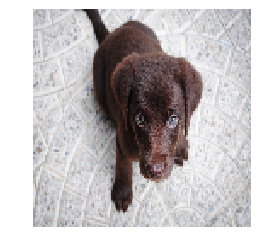

In [ ]:
pipe = Pipeline([f2,f3])
t = pipe(TEST_IMAGE)
ax = pipe.show(t)

In [ ]:
test_fig_exists(ax)

In [ ]:
#Check filtering is properly applied
add1 = B()
add1.filt = 1
pipe = Pipeline([neg_tfm, A(), add1])
test_eq(pipe(start), -2)
test_eq(pipe(start, filt=1), -1)
test_eq(pipe(start, filt=0), -2)
test_eq(pipe(start), -2)
for t in [None, 0, 1]: test_eq(pipe.decode(pipe(start, filt=t), filt=t), start)
for t in [None, 0, 1]: test_stdout(lambda: pipe.show(pipe(start, filt=t), filt=t), "-2.0")

### Methods

In [ ]:
#TODO: method examples

In [ ]:
show_doc(Pipeline.__call__)

<h4 id="<code>Pipeline.__call__</code>" class="doc_header"><code>Pipeline.__call__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#Pipeline--" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.__call__</code>(**`o`**, **`filt`**=*`None`*)

Compose `__call__` of all `tfms` on `o`

In [ ]:
show_doc(Pipeline.decode)

<h4 id="<code>Pipeline.decode</code>" class="doc_header"><code>Pipeline.decode</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#Pipeline--" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.decode</code>(**`o`**, **`filt`**=*`None`*)

Compose [`decode`](/data.core.html#decode) of all `tfms` on `o`

In [ ]:
show_doc(Pipeline.decode_batch)

<h4 id="<code>Pipeline.decode_batch</code>" class="doc_header"><code>Pipeline.decode_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#Pipeline--" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.decode_batch</code>(**`b`**, **`filt`**=*`None`*, **`max_rows`**=*`10`*)

[`decode`](/data.core.html#decode) all sample in a the batch `b`

In [ ]:
pipe.set_as_item(False)
t = tensor([1,2,3])
test_eq(pipe.decode_batch([t,t+1], filt=1, max_rows=2), [(0,-1),(-1,-2)])

In [ ]:
show_doc(Pipeline.setup)

<h4 id="<code>Pipeline.setup</code>" class="doc_header"><code>Pipeline.setup</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#Pipeline--" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.setup</code>(**`items`**=*`None`*)

Call each tfm's `setup` in order

During the setup, the `Pipeline` starts with no transform and adds them one at a time, so that during its setup, each transfrom get the items processed up to its point and not after. Depending on the attribute `add_before_setup`, the transform is added after the setup (default behaivor) so it's not called on the items used for the setup, or before (in which case it's called on the values used for setup).

In [ ]:
#hide
#Test is below with TfmdList

## TfmdList -

In [ ]:
#export
class TfmdList():
    "A `Pipeline` of `tfms` applied to a collection of `items`"
    def __init__(self, items, tfms, do_setup=True, as_item=True):
        self.items = L(items)
        self._mk_pipeline(tfms.tfms if isinstance(tfms,TfmdList) else tfms, do_setup=do_setup, as_item=as_item)

    def _mk_pipeline(self, tfms, do_setup, as_item):
        if isinstance(tfms,Pipeline): self.tfms = tfms
        else:
            self.tfms = Pipeline(tfms, as_item=as_item)
            if do_setup: self.setup()
        
    def __getitem__(self, i): return self.get(i)
    def get(self, i, filt=None):
        "Transformed item(s) at `i`"
        its = self.items[i]
        if is_iter(i): return L(self._get(it, filt=filt) for it in its)
        return self._get(its, filt=filt)
        
    def _get(self, it, filt=None): return self.tfms(it, filt=filt)
    
    def subset(self, idxs): return self.__class__(self.items[idxs], self.tfms, do_setup=False)
    def decode_at(self, idx, filt=None): return self.decode(self.get(idx,filt=filt), filt=filt)
    def show_at(self, idx, filt=None, **kwargs): return self.show(self.get(idx,filt=filt), filt=filt, **kwargs)
    
    # Standard dunder magics
    def __eq__(self, b): return all_equal(self, b)
    def __len__(self): return len(self.items)
    def __iter__(self): return (self[i] for i in range_of(self))
    def __repr__(self): return f"{self.__class__.__name__}: {self.items}\ntfms - {self.tfms.fs}"
    
    # Delegating to `self.tfms`
    def show(self, o, **kwargs): return self.tfms.show(o, **kwargs)
    def setup(self): self.tfms.setup(self)
    def decode(self, x, **kwargs): return self.tfms.decode(x, **kwargs)
    def __call__(self, x, **kwargs): return self.tfms.__call__(x, **kwargs)

In [ ]:
add_docs(TfmdList,
         setup="Transform setup with self",
         decode="From `Pipeline",
         show="From `Pipeline",
         decode_at="Decoded item at `idx`",
         show_at="Show item at `idx`",
         subset="New `TfmdList` that only includes items at `idxs`")

`tfms` can either be a `Pipeline` or a list of transforms.

In [ ]:
tl = TfmdList([1.,2.,3.], [neg_tfm, int_tfm])
t = tl[1]
test_eq_type(t, Int(-2))
test_eq(tl.decode_at(1), 2)
test_eq_type(tl.decode(t), Float(2.0))
test_stdout(lambda: tl.show_at(2), '-3')
tl

AttributeError: 'Transform' object has no attribute 'fs'

In [ ]:
p2 = tl.subset([0,2])
test_eq(p2, [-1,-3])
test_eq(map(type, p2), (Int,Int))

Here's how we can use `TfmdList.setup` to implement a simple category list, getting labels from a mock file list:

In [ ]:
class _Cat(Transform):
    order = 1
    def __init__(self, subset_idx=None): self.subset_idx = subset_idx
    def encodes(self, o)->int: return self.o2i[o]
    def decodes(self, o)->Str: return self.vocab[o]
    def setup(self, items): 
        if self.subset_idx is not None: items = items.subset(self.subset_idx)
        self.vocab,self.o2i = uniqueify(L(items), sort=True, bidir=True)

def _lbl(o)->Str: return o.split('_')[0]

test_fns = ['dog_0.jpg','cat_0.jpg','cat_2.jpg','cat_1.jpg','dog_1.jpg']
tcat = _Cat()
# Check that tfms are sorted by `order`
tl = TfmdList(test_fns, [tcat,_lbl])

test_eq(tcat.vocab, ['cat','dog'])

In [ ]:
test_eq(tl, (1,0,0,0,1))
t = L(tl)
test_eq(t, [1,0,0,0,1])
test_eq(tl[-1], 1)
test_eq(tl[0,1], (1,0))
test_eq([tl.decode(o) for o in t], ('dog','cat','cat','cat','dog'))
test_stdout(lambda:tl.show_at(0), "dog")
tl

AttributeError: 'Transform' object has no attribute 'fs'

In [ ]:
class B(Transform):
    def __init__(self):   self.a = 2
    def encodes(self, x): return x+self.a
    def decodes(self, x): return x-self.a
    def setup(self, items): self.a = tensor(items).float().mean().item()

tl1 = TfmdList([1,2,3,4], B())
test_eq(tl1.tfms[0].a, 2.5)

In [ ]:
#hide
#Check filtering is properly applied
tl1 = TfmdList([1.,2.,3.,4.], [neg_tfm, A(), add1])
test_eq(tl1[2], -3)
test_eq(tl1.get(2, filt=1), -2)
test_eq(tl1.get(2, filt=0), -3)
test_eq(tl1.get([2,2], filt=1), [-2,-2])
for t in [None, 0, 1]: test_eq(tl1.decode(tl1.get(1, filt=t), filt=t), 2)
for t in [None, 0, 1]: test_eq(tl1.decode_at(1, filt=t), 2)
for t in [None, 0, 1]: test_stdout(lambda: tl1.show_at(1, filt=t), "-2.0")

### Methods

In [ ]:
show_doc(TfmdList.get)

<h4 id="<code>TfmdList.get</code>" class="doc_header"><code>TfmdList.get</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.get</code>(**`i`**, **`filt`**=*`None`*)

Transformed item(s) at `i`

In [ ]:
show_doc(TfmdList.decode_at)

<h4 id="<code>TfmdList.decode_at</code>" class="doc_header"><code>TfmdList.decode_at</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.decode_at</code>(**`idx`**, **`filt`**=*`None`*)

Decoded item at `idx`

In [ ]:
test_eq(tl.decode_at(1),tl.decode(tl[1]))

In [ ]:
show_doc(TfmdList.show_at)

<h4 id="<code>TfmdList.show_at</code>" class="doc_header"><code>TfmdList.show_at</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.show_at</code>(**`idx`**, **`filt`**=*`None`*, **\*\*`kwargs`**)

Show item at `idx`

In [ ]:
test_stdout(lambda: tl.show_at(1), 'cat')

In [ ]:
show_doc(TfmdList.subset)

<h4 id="<code>TfmdList.subset</code>" class="doc_header"><code>TfmdList.subset</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.subset</code>(**`idxs`**)

New [`TfmdList`](/pipeline.html#TfmdList) that only includes items at `idxs`

## TfmdDS -

`tfms` is a list of objects that can be:
- one transform
- a list of transforms
- a `Pipeline`

In [ ]:
#export
@docs
class TfmdDS(TfmdList):
    "A dataset that creates a tuple from each `type_tfms`, passed thru `ds_tfms`"
    def __init__(self, items, type_tfms=None, ds_tfms=None, do_setup=True):
        self.items = L(items)
        self.tls = [TfmdList(items, t, do_setup=do_setup) for t in L(type_tfms)]
        self._mk_pipeline(ds_tfms, do_setup=do_setup, as_item=False)

    def _get(self, it, filt=None):
        o = tuple(tl._get(it, filt=filt) for tl in self.tls)
        return self.tfms(o, filt=filt)
    
    def decode(self, o, filt=None):
        o = self.tfms.decode(o, filt=filt)
        return tuple(it.decode(o_, filt=filt) for o_,it in zip(o,self.tls))

    def show(self, o, ctx=None, filt=None, **kwargs):
        # Currently we don't support showing at tuple level, so we just decode all tfms at once
        o = super().decode(o, filt=filt)
        for o_,it in zip(o,self.tls): ctx = it.show(o_, ctx=ctx, filt=filt, **kwargs)
        return ctx
    
    def setup(self): self.tfms.setup(self)
    def subset(self, idxs): return self.__class__(self.items[idxs], self.tls, self.tfms, do_setup=False)
    def __repr__(self): return f"{self.__class__.__name__}: tls - {self.tls}\nds tfms - {self.tfms}"

    _docs=dict(
        get="Call all `tfms` on `items[i]` then all `tuple_tfms` on the result",
        decode="Compose `decode` of all `tuple_tfms` then all `tfms` on `i`",
        show="Show item `o` in `ctx`",
        subset="New `TfmdDS` that only includes items at `idxs`",
        setup="Go through the transforms in order and call their potential setup on `items`")

In [ ]:
items = [1,2,3,4]
tds = TfmdDS(items, [[neg_tfm,int_tfm]])
test_eq(*tds[0], -1)
test_eq(tds[0,1,2], [(-1,),(-2,),(-3,)])
test_eq(tds.decode_at(0), (1,))
test_stdout(lambda:tds.show_at(1), '-2')

In [ ]:
class A(Transform):
    def encodes(self, o)->float: return (o-self.m)/self.s
    def decodes(self, o): return (o*self.s)+self.m
    def setup(self, items):
        its = tensor(items).float()
        self.m,self.s = its.mean(),its.std()

In [ ]:
list(tds)

[(-1,), (-2,), (-3,), (-4,)]

In [ ]:
items = [1,2,3,4]
nrm = A()
tds = TfmdDS(items, [[neg_tfm,int_tfm], [neg_tfm,nrm]])

x,y = zip(*tds)
test_close(tensor(y).mean(), 0)
test_close(tensor(y).std(), 1)
test_eq(x, (-1,-2,-3,-4,))
test_eq(nrm.m, -2.5)
test_stdout(lambda:tds.show_at(1), '-2')
# test_eq(tds.m, tds.type_tfms[1].fs[1].m)
# test_eq(tds.s, tds.type_tfms[1].fs[1].s)
#Attributes are set to all parents progressively
# test_eq(tds.tls[1].m, tds.type_tfms[1].fs[1].m)
# test_eq(tds.tls[1].s, tds.type_tfms[1].fs[1].s)

In [ ]:
#hide
#Check filtering is properly applied
class B(Transform):
    def encodes(self, x)->int: return x+1
    def decodes(self, x)->Int: return x-1
add1 = B()
add1.filt = 1

tds = TfmdDS(items, [neg_tfm, [neg_tfm,int_tfm,add1]])
test_eq(tds[1], [-2,-2])
test_eq(tds.get(1, filt=1), [-2,-1])
test_eq(tds.get(1, filt=0), [-2,-2])
test_eq(tds.get([1,1], filt=1), [[-2,-1], [-2,-1]])
for t in [None, 0, 1]: test_eq(tds.decode(tds.get(1, filt=t), filt=t), [2,2])
for t in [None, 0, 1]: test_eq(tds.decode_at(1, filt=t), [2,2])
for t in [None, 0, 1]: test_stdout(lambda: tds.show_at(1, filt=t), "-2")

ss = tds.subset([1,2])
test_eq(ss[0], tds[1])
test_eq(ss[1], tds[2])
test_eq(len(ss), 2)

### Methods

In [ ]:
# TODO: add examples to method docs, or move them from above

In [ ]:
show_doc(TfmdDS.get)

<h4 id="<code>TfmdList.get</code>" class="doc_header"><code>TfmdList.get</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.get</code>(**`i`**, **`filt`**=*`None`*)

Call all `tfms` on `items[i]` then all `tuple_tfms` on the result

In [ ]:
show_doc(TfmdDS.decode)

<h4 id="<code>TfmdDS.decode</code>" class="doc_header"><code>TfmdDS.decode</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdDS--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDS.decode</code>(**`o`**, **`filt`**=*`None`*)

Compose [`decode`](/data.core.html#decode) of all `tuple_tfms` then all `tfms` on `i`

In [ ]:
show_doc(TfmdDS.decode_at)

<h4 id="<code>TfmdList.decode_at</code>" class="doc_header"><code>TfmdList.decode_at</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.decode_at</code>(**`idx`**, **`filt`**=*`None`*)

Decoded item at `idx`

In [ ]:
show_doc(TfmdDS.show)

<h4 id="<code>TfmdDS.show</code>" class="doc_header"><code>TfmdDS.show</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdDS--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDS.show</code>(**`o`**, **`ctx`**=*`None`*, **`filt`**=*`None`*, **\*\*`kwargs`**)

Show item `o` in `ctx`

In [ ]:
show_doc(TfmdDS.show_at)

<h4 id="<code>TfmdList.show_at</code>" class="doc_header"><code>TfmdList.show_at</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdList--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdList.show_at</code>(**`idx`**, **`filt`**=*`None`*, **\*\*`kwargs`**)

Show item at `idx`

In [ ]:
show_doc(TfmdDS.setup)

<h4 id="<code>TfmdDS.setup</code>" class="doc_header"><code>TfmdDS.setup</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdDS--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDS.setup</code>()

Go through the transforms in order and call their potential setup on `items`

In [ ]:
show_doc(TfmdDS.subset)

<h4 id="<code>TfmdDS.subset</code>" class="doc_header"><code>TfmdDS.subset</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02a_pipeline.ipynb#TfmdDS--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDS.subset</code>(**`idxs`**)

New [`TfmdDS`](/pipeline.html#TfmdDS) that only includes items at `idxs`

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 02_transforms.ipynb.
Converted 02a_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_vision_augment.ipynb.
Converted 09_data_block.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 13_callback_schedule.ipynb.
Converted 14_callback_hook.ipynb.
Converted 15_callback_progress.ipynb.
Converted 16_callback_tracker.ipynb.
Converted 17_callback_fp16.ipynb.
Converted 30_text_core.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
